# Использование предобученных сеток 

Скрипт взят с Coursera из курса itroduction to deep learning, где я являлся ментором.

В этой тетрадке вы попробуете использовать веса предобученной сетки [InceptionV3](https://research.googleblog.com/2016/03/train-your-own-image-classifier-with.html) для [классификации цветов.](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html)


InceptionV3 архитектура: 

![](https://4.bp.blogspot.com/-TMOLlkJBxms/Vt3HQXpE2cI/AAAAAAAAA8E/7X7XRFOY6Xo/s1600/image03.png)

Датасет содержит $102$ категории цветов, обычно встречающихся в Великобритании. Каждый класс содержит от $40$ до $258$ изображений.

![](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/T_shapeiso.jpg)

Ссылки с датасетом: 

- http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html
- http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
- http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat


In [1]:
import keras
from keras import backend as K
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import cv2  # препроцессинг картинок
from sklearn.model_selection import train_test_split

import tarfile  # Чтобы открывать tar архивы прямо из питона
import scipy.io

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/Cellar/python/3.6.4_4/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## 1. Подготовка изображений 

Мы будем обрезать картинки и преобразовывать их к размеру `IMG_SIZE x IMG_SIZE`


In [2]:
IMG_SIZE = 250

# Функция преобразует сырые изображения в матрицы 

def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

Будем обрезать большие картинки и центрировать их.

<img src="https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/week3/images/center_crop.jpg" style="width:50%">

In [3]:
# Функция для обрезания картинок 
def image_center_crop(img):
    w = img.shape[0]
    h = img.shape[1]
    if w > h :
        cropped_img = img[(w-h)//2:w-(w-h)//2,:,:]
    elif w < h:
        cropped_img = img[:,(h-w)//2:h-(h-w)//2,:]
    else:
        cropped_img = img
    return cropped_img

In [4]:
# Функция для итоговой подготовки картинок 
def prepare_raw_bytes_for_model(raw_bytes, normalize_for_model=True):
    img = decode_image_from_raw_bytes(raw_bytes)  # Распаковка из байт в матрицу 
    img = image_center_crop(img)                  # Обрезаем картинку
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))   # Делаем ресайз картинки 
    
    # Надо ли делать нормализацию
    if normalize_for_model:
        img = img.astype("float32")               
        img = keras.applications.inception_v3.preprocess_input(img)
    return img

In [5]:
# reads bytes directly from tar by filename (slow, but ok for testing, takes ~6 sec)
def read_raw_from_tar(tar_fn, fn):
    with tarfile.open(tar_fn) as f:
        m = f.getmember(fn)
        return f.extractfile(m).read()

(500, 591, 3)


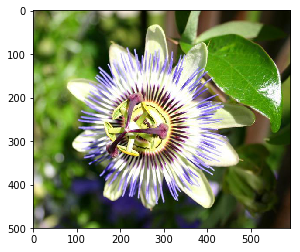

(250, 250, 3)


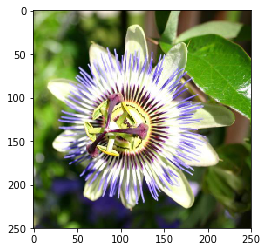

In [7]:
# протестируем обрезку картинок
raw_bytes = read_raw_from_tar("102flowers.tgz", "jpg/image_00001.jpg")

img = decode_image_from_raw_bytes(raw_bytes)
print(img.shape)
plt.imshow(img)
plt.show()

img = prepare_raw_bytes_for_model(raw_bytes, normalize_for_model=False)
print(img.shape)
plt.imshow(img)
plt.show()

## 2. Подготовка к обучению модели 

In [8]:
# считываем все файлы из архива
def get_all_filenames(tar_fn):
    with tarfile.open(tar_fn) as f:
        return [m.name for m in f.getmembers() if m.isfile()]

all_files = sorted(get_all_filenames("102flowers.tgz"))  # список из фвйлов
all_labels = scipy.io.loadmat('imagelabels.mat')['labels'][0] - 1  # считываем метки (0, 1, 2, ...)

N_CLASSES = len(np.unique(all_labels))
print(N_CLASSES)

102


In [9]:
# делим выборку на тренировочную и тестовую части
tr_files, te_files, tr_labels, te_labels = \
    train_test_split(all_files, all_labels, test_size=0.2, random_state=42, stratify=all_labels)

In [10]:
# генератор выдаёт необработанные байты с меткой класса из tar-файла
def raw_generator_with_label_from_tar(tar_fn, files, labels):
    label_by_fn = dict(zip(files, labels))
    with tarfile.open(tar_fn) as f:
        for m in f.getmembers():
            if m.name in label_by_fn:
                yield f.extractfile(m).read(), label_by_fn[m.name]

In [11]:
# генератор батчей
BATCH_SIZE = 32

def batch_generator(items, batch_size):
    """
    Implement batch generator that yields items by batches of size batch_size.
    Remember about the last batch that can be smaller than batch_size!
    """
    cur_batch = [ ]
    for item in items:
        cur_batch.append(item)
        if len(cur_batch) == batch_size:
            yield cur_batch
            cur_batch = [ ]
    if cur_batch:
        yield cur_batch

In [12]:
list(batch_generator(range(10), 3))

[[0, 1, 2], [3, 4, 5], [6, 7, 8], [9]]

In [13]:
def train_generator(files, labels):
    while True:
        for batch in batch_generator(raw_generator_with_label_from_tar(
                "102flowers.tgz", files, labels), BATCH_SIZE):
            # готовим батч из изображений
            batch_imgs = []
            batch_targets = []
            for raw, label in batch:
                img = prepare_raw_bytes_for_model(raw)
                batch_imgs.append(img)
                batch_targets.append(label)
            # объединяем изображения в 4D тезор [batch_size, img_size, img_size, 3]
            batch_imgs = np.stack(batch_imgs, axis=0)
            # конвертируем метки класса в 2D тензор [batch_size, num_classes]
            batch_targets = keras.utils.np_utils.to_categorical(batch_targets, N_CLASSES)
            yield batch_imgs, batch_targets

In [14]:
def inception(use_imagenet=True):
    # подгружаем предобученную модель 
    model = keras.applications.InceptionV3(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                          weights='imagenet' if use_imagenet else None)
    
    # add global pooling just like in InceptionV3
    new_output = keras.layers.GlobalAveragePooling2D()(model.output)
   
    # add new dense layer for our labels
    new_output = keras.layers.Dense(N_CLASSES, activation='softmax')(new_output)
    model = keras.engine.training.Model(model.inputs, new_output)
    return model

In [15]:
model = inception()

In [16]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 250, 250, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 124, 124, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 124, 124, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 124, 124, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [17]:
# how many layers our model has
print(len(model.layers))

313


In [18]:
# set all layers trainable by default and prepare batch norm for fine-tuning
for layer in model.layers:
    layer.trainable = True
    if isinstance(layer, keras.layers.BatchNormalization):
        # we do aggressive exponential smoothing of batch norm 
        # parameters to faster adjust to our new dataset
        layer.momentum = 0.8
    
# fix deep layers (fine-tuning only last 50)
for layer in model.layers[:-50]:
    layer.trainable = False

In [19]:
# compile new model
model.compile(
    loss='categorical_crossentropy',  # we train 102-way classification
    optimizer=keras.optimizers.adamax(lr=1e-2),  # we can take big lr here because we fixed first layers
    metrics=['accuracy']  # report accuracy during training
)

In [20]:
# fine tune for 2 epochs
model.fit_generator(
    train_generator(tr_files, tr_labels), 
    steps_per_epoch=len(tr_files) // BATCH_SIZE, 
    epochs=2,
    validation_data=train_generator(te_files, te_labels), 
    validation_steps=len(te_files) // BATCH_SIZE // 2,
)

Epoch 1/2
204/204 [==============================] - 1427s 7s/step - loss: 1.8206 - acc: 0.6385 - val_loss: 0.4003 - val_acc: 0.8925
Epoch 2/2
204/204 [==============================] - 1396s 7s/step - loss: 0.1896 - acc: 0.9605 - val_loss: 0.2990 - val_acc: 0.9212


In [21]:
# Accuracy on validation set
test_accuracy = model.evaluate_generator(
    train_generator(te_files, te_labels), 
    len(te_files) // BATCH_SIZE // 2
)[1]

In [22]:
test_accuracy

0.9325

На последок посмотрим на наши прогнозы.

In [23]:
batch_targets=[]
batch_imgs = []
dict_lab_files = dict(zip(te_files,te_labels))

with tarfile.open('102flowers.tgz') as f:
    for m in f.getmembers():  # listing members is slow, but then it's fast!
        if m.name in te_files:
            raw = f.extractfile(m).read()
            img = prepare_raw_bytes_for_model(raw)
            batch_imgs.append(img)
            batch_targets.append(dict_lab_files[m.name])
            
# stack images into 4D tensor [batch_size, img_size, img_size, 3]
batch_imgs = np.stack(batch_imgs, axis=0)
print(model.predict(batch_imgs).shape)
predictions = np.argmax(model.predict(batch_imgs),axis=1)

(1638, 102)


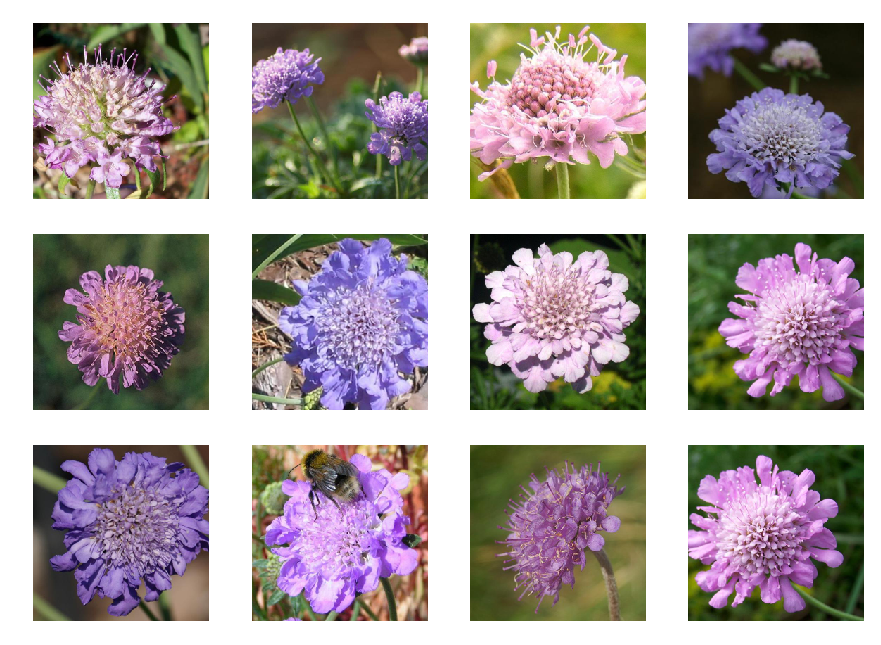

In [24]:
class_index = 21
number_images = 12

rows = number_images // 4
if number_images % 4 != 0: rows += 1
cols = 4
fig = plt.figure(figsize=(4 * cols - 1, 4 * rows - 1))
i=0
plt.style.use('dark_background')
for index in list(np.argwhere(predictions==class_index).flatten())[:number_images]:
    i+=1
    ax = fig.add_subplot(rows, cols, i)
    ax.grid('off')
    ax.axis('off')
    ax.imshow((batch_imgs[index]+1)/2) #Try simply ax.imshow(batch_imgs[index]) if you have error
    ax.set_title('Predicted: '+str(predictions[index])+'. Real: '+str(batch_targets[index]))
plt.show()